In [1]:
import gc
import torch

/home/nastya/anaconda3/envs/torch_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cuda maintenance
gc.collect()
torch.cuda.empty_cache()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Torch device: ", device)

Torch device:  cuda


In [4]:
import numpy as np
import pandas as pd
import torch
from IPython.display import display
from torch import nn
from torch.utils.data import DataLoader

from sequence_dataset import SequenceDataset
from shallow_regression_lstm import ShallowRegressionLSTM

## Read data

---

In [5]:
df = pd.read_csv('../input_data/data.csv')

In [6]:
df.columns

Index(['Unnamed: 0', 'Timestamp', 'FIT101', 'LIT101', 'MV101', 'P101', 'P102',
       'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203',
       'P204', 'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302',
       'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401',
       'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502',
       'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501',
       'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603',
       'Normal/Attack'],
      dtype='object')

In [7]:
df.tail()

,Unnamed: 0,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
946714,946714,2016-01-02 14:59:55,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,...,2,1,251.1535,0.865024,189.0220,0.0,1,1,1,0
946715,946715,2016-01-02 14:59:56,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,...,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,0
946716,946716,2016-01-02 14:59:57,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,...,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,0
946717,946717,2016-01-02 14:59:58,2.521218,520.7271,2,2,1,168.0979,8.638683,301.9226,...,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,0
946718,946718,2016-01-02 14:59:59,2.501681,521.1196,2,2,1,168.0979,8.638683,301.9226,...,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,0


In [8]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%Y-%m-%d %H:%M:%S")
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.sort_values(by=['Timestamp'], inplace=True)

In [9]:
df.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,2015-12-22 16:00:00,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,0
1,2015-12-22 16:00:01,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,2.468587,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,0
2,2015-12-22 16:00:02,2.439548,260.9131,2,2,1,244.3284,8.19008,306.101,2.467305,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,0
3,2015-12-22 16:00:03,2.428338,260.2850,2,2,1,244.3284,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,0
4,2015-12-22 16:00:04,2.424815,259.8925,2,2,1,244.4245,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,0


In [10]:
df.dropna(inplace=True)

In [11]:
df.set_index('Timestamp', inplace=True)

In [12]:
df.tail()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-02 14:59:55,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.1535,0.865024,189.0220,0.0,1,1,1,0
2016-01-02 14:59:56,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,0
2016-01-02 14:59:57,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,2,...,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,0
2016-01-02 14:59:58,2.521218,520.7271,2,2,1,168.0979,8.638683,301.9226,2.460129,2,...,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,0
2016-01-02 14:59:59,2.501681,521.1196,2,2,1,168.0979,8.638683,301.9226,2.458206,2,...,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,0


In [13]:
features = df.columns.values.tolist()
features.remove('Normal/Attack')

In [14]:
# Remove first five hours required for stabilization from dataset
new_start_idx = df.index.get_loc((df.index[0] + pd.DateOffset(hours=5)), method='nearest')
print("Crop measurements before: ", df.index[new_start_idx])
measurements_df = df.drop(df[(df.index < df.index[new_start_idx])].index)

Crop measurements before:  2015-12-22 21:00:00


In [15]:
# Split to categorical and numerical features

categorical_features = []
numerical_features = []
const_features = []

for feature in features:
    values_count = len(measurements_df[feature].unique())
    if values_count == 1:
        const_features.append(feature)
    elif values_count < 10: # 
        categorical_features.append(feature)
    else:
        numerical_features.append(feature)    

In [16]:
# Remove const features
measurement_features = [f for f in features if f not in const_features]
measurements_df.drop(const_features, axis=1, inplace=True)

In [17]:
measurements_df.tail()

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,FIT502,FIT503,FIT504,P501,PIT501,PIT502,PIT503,FIT601,P602,Normal/Attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-02 14:59:55,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,1.288971,0.734885,0.306569,2,251.1535,0.865024,189.0220,0.0,1,0
2016-01-02 14:59:56,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,1.272704,0.734885,0.306569,2,251.0734,0.865024,188.9259,0.0,1,0
2016-01-02 14:59:57,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,2,...,1.269502,0.734885,0.306569,2,251.0734,0.865024,188.9259,0.0,1,0
2016-01-02 14:59:58,2.521218,520.7271,2,2,1,168.0979,8.638683,301.9226,2.460129,2,...,1.263866,0.734885,0.307978,2,251.0734,0.865024,188.9259,0.0,1,0
2016-01-02 14:59:59,2.501681,521.1196,2,2,1,168.0979,8.638683,301.9226,2.458206,2,...,1.272704,0.734885,0.308298,2,251.0734,0.865024,188.9259,0.0,1,0


## Feature visualization

---

In [18]:
# Find timestamp for first attack

attacks_timestamps = measurements_df.loc[measurements_df['Normal/Attack'] == 1].index
print("First attack happened: ", attacks_timestamps[0])

First attack happened:  2015-12-28 10:29:14


In [19]:
print(categorical_features)
print(numerical_features) 

['MV101', 'P101', 'P102', 'MV201', 'P201', 'P203', 'P204', 'P205', 'P206', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'P402', 'P403', 'UV401', 'P501', 'P602']
['FIT101', 'LIT101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301', 'FIT301', 'LIT301', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601']


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

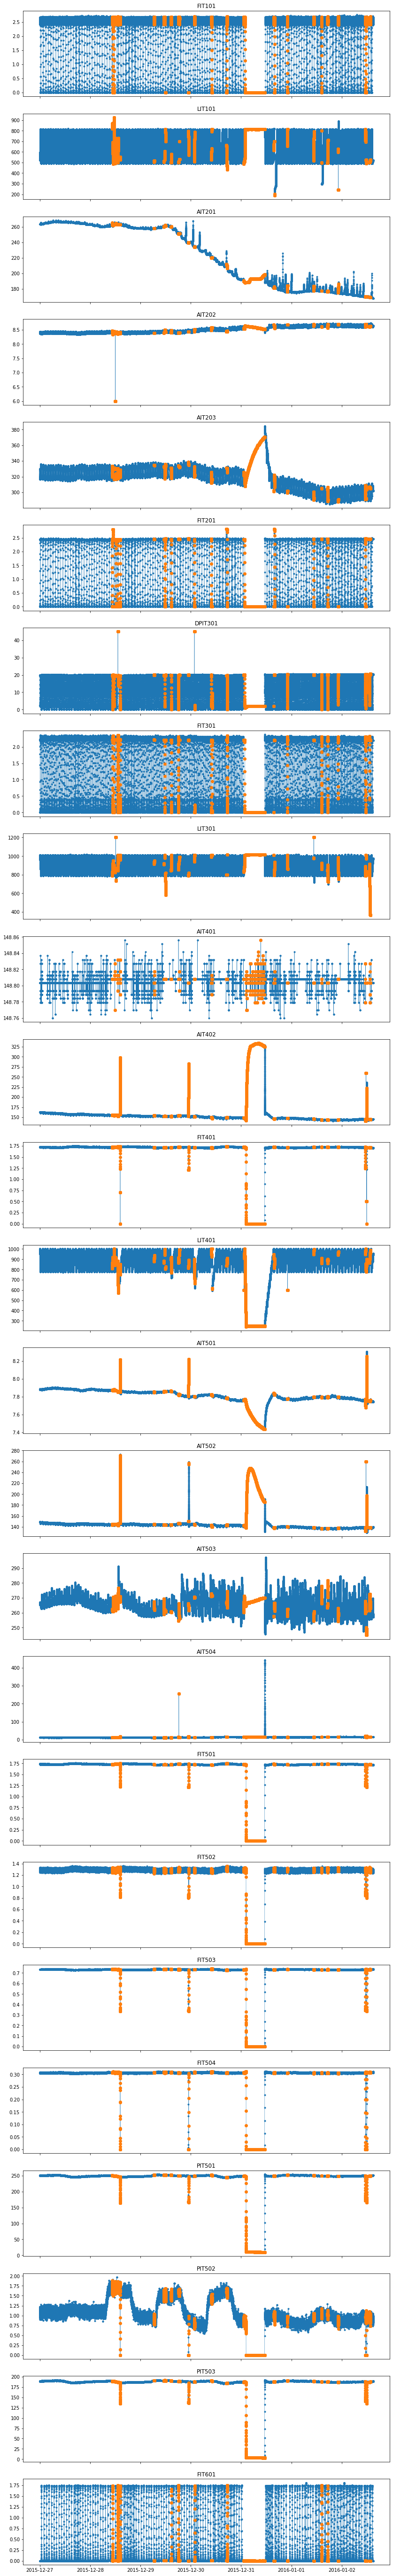

In [21]:
start, end = '2015-12-27', '2016-01-02'
features_to_plot = numerical_features

fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(14, 100), sharex=True)
for name, ax in zip(features_to_plot, axes):
    ax.plot(measurements_df.loc[start:end, name], marker='.', linestyle='-', linewidth=0.5, label=name)
    ax.plot(measurements_df.loc[attacks_timestamps, name], marker='o', linestyle='None')
    ax.set_title(name)
    # Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

### Preprocess data before training


1. Normalize numerical features

---


In [22]:
from sklearn import preprocessing

x = measurements_df[numerical_features].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_df = pd.DataFrame(data=x_scaled, columns=numerical_features, index=measurements_df.index)

In [23]:
normalized_df.head()

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 21:00:00,0.882107,0.436037,0.90279,0.981449,0.632746,0.870257,0.437857,0.929319,0.719989,0.0,...,0.499084,0.005507,0.975427,0.926173,0.983319,0.981837,0.974877,0.601626,0.972170,0.000036
2015-12-22 21:00:01,0.878162,0.436251,0.90279,0.981449,0.634563,0.869623,0.437857,0.929319,0.720277,0.0,...,0.499084,0.005507,0.975427,0.926173,0.983319,0.981837,0.974877,0.601626,0.971759,0.000036
2015-12-22 21:00:02,0.877118,0.437479,0.90279,0.981449,0.636653,0.869623,0.437572,0.929319,0.720564,0.0,...,0.499084,0.005507,0.975427,0.926173,0.983319,0.983265,0.973854,0.601626,0.971431,0.000036
2015-12-22 21:00:03,0.877118,0.438013,0.90279,0.981449,0.637561,0.870302,0.437572,0.929319,0.720851,0.0,...,0.499084,0.005507,0.975427,0.934073,0.983319,0.983265,0.973215,0.601626,0.971349,0.000036
2015-12-22 21:00:04,0.892782,0.438814,0.90279,0.981449,0.639288,0.870302,0.438213,0.929319,0.721282,0.0,...,0.499084,0.005507,0.975427,0.934073,0.981958,0.983265,0.973215,0.552846,0.970528,0.000036


In [24]:
# Add categorical features and target to normalized df
normalized_df = normalized_df.join(measurements_df[categorical_features + ['Normal/Attack']])

In [25]:
normalized_df.head()

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV303,MV304,P301,P302,P402,P403,UV401,P501,P602,Normal/Attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 21:00:00,0.882107,0.436037,0.90279,0.981449,0.632746,0.870257,0.437857,0.929319,0.719989,0.0,...,1,1,1,2,2,1,2,2,1,0
2015-12-22 21:00:01,0.878162,0.436251,0.90279,0.981449,0.634563,0.869623,0.437857,0.929319,0.720277,0.0,...,1,1,1,2,2,1,2,2,1,0
2015-12-22 21:00:02,0.877118,0.437479,0.90279,0.981449,0.636653,0.869623,0.437572,0.929319,0.720564,0.0,...,1,1,1,2,2,1,2,2,1,0
2015-12-22 21:00:03,0.877118,0.438013,0.90279,0.981449,0.637561,0.870302,0.437572,0.929319,0.720851,0.0,...,1,1,1,2,2,1,2,2,1,0
2015-12-22 21:00:04,0.892782,0.438814,0.90279,0.981449,0.639288,0.870302,0.438213,0.929319,0.721282,0.0,...,1,1,1,2,2,1,2,2,1,0


## Split to test and train dataframes


---

In [26]:
print("There are timestamps with attack:",len(attacks_timestamps),
      "starting with", attacks_timestamps[0],
      "Last attack timestamp: ", attacks_timestamps[-1])

There are timestamps with attack: 54621 starting with 2015-12-28 10:29:14 Last attack timestamp:  2016-01-02 13:41:11


In [27]:
normalized_df.shape

(928719, 46)

In [28]:
# For Attack prediction:
train_start, train_end = '2015-12-27', '2015-12-30 11:59:59'
# For Signal prediction:
#train_start, train_end = '2015-12-23', '2015-12-26'
train_df = normalized_df.loc[train_start:train_end]
train_df.tail()

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV303,MV304,P301,P302,P402,P403,UV401,P501,P602,Normal/Attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-30 11:59:55,0.910652,0.444687,0.467954,0.827789,0.145375,0.866359,0.436576,0.928240,0.691312,0.999677,...,1,1,1,2,2,1,2,2,1,0
2015-12-30 11:59:56,0.904154,0.444740,0.467954,0.827789,0.145375,0.866359,0.435723,0.928240,0.691359,0.999677,...,1,1,1,2,2,1,2,2,1,0
2015-12-30 11:59:57,0.893827,0.444526,0.467954,0.827789,0.145375,0.866359,0.436932,0.928456,0.691216,0.999677,...,1,1,1,2,2,1,2,2,1,0
2015-12-30 11:59:58,0.887329,0.444580,0.467954,0.827789,0.145375,0.866359,0.437430,0.928456,0.691790,0.999677,...,1,1,1,2,2,1,2,2,1,0
2015-12-30 11:59:59,0.881759,0.444526,0.467954,0.827789,0.145375,0.866359,0.437430,0.928456,0.691455,0.999677,...,1,1,1,2,2,1,2,2,1,0


In [29]:
# For Attack prediction:
validation_start, validation_end = '2015-12-30 12:00:00', '2016-1-1 11:59:59'
# For Signal prediction:
#validation_start, validation_end = '2015-12-27', '2015-12-28 10:00:00'
validation_df = normalized_df.loc[validation_start:validation_end]
validation_df.tail()

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV303,MV304,P301,P302,P402,P403,UV401,P501,P602,Normal/Attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 11:59:55,0.895103,0.515642,0.094144,0.899097,0.015719,0.0,0.000996,0.006901,0.749577,0.999645,...,2,1,1,1,2,1,2,2,1,0
2016-01-01 11:59:56,0.888953,0.517137,0.094144,0.899097,0.015719,0.0,0.000996,0.012023,0.749337,0.999645,...,2,1,1,1,2,1,2,2,1,0
2016-01-01 11:59:57,0.883964,0.517938,0.094144,0.899097,0.015719,0.0,0.000996,0.032510,0.749337,0.999645,...,2,1,1,1,2,1,2,2,1,0
2016-01-01 11:59:58,0.879902,0.519112,0.094144,0.899097,0.015719,0.0,0.000996,0.056610,0.749768,0.999645,...,2,1,1,1,2,1,2,2,1,0
2016-01-01 11:59:59,0.878046,0.519913,0.094144,0.899848,0.015719,0.0,0.000996,0.085724,0.749960,0.999645,...,2,1,1,1,2,1,2,2,1,0


In [30]:
# For Attack prediction:
test_start = '2016-1-1 12:00:00'
# For Signal prediction:
#test_start = '2015-12-29'
test_df = normalized_df.loc[test_start:]
test_df.tail()

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,MV303,MV304,P301,P302,P402,P403,UV401,P501,P602,Normal/Attack
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-02 14:59:55,0.927477,0.448477,0.000613,0.883013,0.058786,0.870030,0.453294,0.924412,0.729325,0.999645,...,1,1,1,2,2,1,2,2,1,0
2016-01-02 14:59:56,0.923532,0.449652,0.000613,0.883013,0.058786,0.870030,0.453294,0.924412,0.729373,0.999645,...,1,1,1,2,2,1,2,2,1,0
2016-01-02 14:59:57,0.917150,0.450026,0.000613,0.883013,0.058786,0.870257,0.451800,0.923981,0.728990,0.999645,...,1,1,1,2,2,1,2,2,1,0
2016-01-02 14:59:58,0.913437,0.450079,0.000613,0.883013,0.058786,0.870257,0.451018,0.923981,0.728942,0.999645,...,1,1,1,2,2,1,2,2,1,0
2016-01-02 14:59:59,0.906359,0.450613,0.000613,0.883013,0.058786,0.869577,0.450804,0.925167,0.729182,0.999645,...,1,1,1,2,2,1,2,2,1,0


In [31]:
from torch import nn
from torch.utils.data import DataLoader
from sequence_dataset import SequenceDataset

def get_train_val_datasets(train_df, validation_df, test_df, target_name, features, sequence_length):
    train_dataset = SequenceDataset(
        train_df,
        target=target_name,
        features=features,
        sequence_length=sequence_length
    )

    validation_dataset = SequenceDataset(
        validation_df,
        target=target_name,
        features=features,
        sequence_length=sequence_length
    )
    
    test_dataset = SequenceDataset(
        test_df,
        target=target_name,
        features=features,
        sequence_length=sequence_length
    )
    
    return train_dataset, validation_dataset, test_dataset

In [33]:
sequence_length = 30*60 # 30 minutes

# For Attack prediction based on all features
train_dataset, validation_dataset, test_dataset = get_train_val_datasets(train_df, validation_df, test_df, 'Normal/Attack',
                                                          categorical_features + numerical_features,
                                                          sequence_length)
num_features_for_train = len(categorical_features + numerical_features)

# For sensor prediction based on actuators states
#train_dataset, validation_dataset, test_dataset = get_train_val_datasets(train_df, validation_df, test_df, 'LIT301',
#                                                          categorical_features,
#                                                          sequence_length)
#num_features_for_train = len(categorical_features)

In [34]:
alpha = 1
num_hidden_units = int(sequence_length/(alpha*(num_features_for_train + 1)))
print(num_hidden_units)

39


In [35]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [36]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # or/and actuators
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)
        
    def init_hidden(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_units)
        return [t.cuda() for t in (h0, c0)]

    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()
        return out

In [37]:
learning_rate = 0.001

shallow_model = ShallowRegressionLSTM(num_sensors=num_features_for_train,
                                      hidden_units=num_hidden_units)
shallow_model = shallow_model.cuda()

loss_function_mse = nn.MSELoss()
optimizer_adam = torch.optim.Adam(shallow_model.parameters(), lr=learning_rate)

In [38]:
def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.cuda()
            y = y.cuda()
            output = model(X.cuda())
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Validation loss: {avg_loss}")

In [ ]:
print("Untrained test\n--------")
test_model(validation_loader, shallow_model, loss_function_mse)
print()

In [39]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        X = X.cuda()
        y = y.cuda()
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    
     
for ix_epoch in range(6):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, shallow_model, loss_function_mse, optimizer=optimizer_adam)
    test_model(validation_loader, shallow_model, loss_function_mse)
    print()

Epoch 0
---------
Train loss: 0.029407451199123986
Validation loss: 0.21896410842036784

Epoch 1
---------
Train loss: 0.0307639988581893
Validation loss: 0.18774544718810235

Epoch 2
---------
Train loss: 0.03122643715608891
Validation loss: 0.17673097792126155

Epoch 3
---------
Train loss: 0.030488889122879354
Validation loss: 0.14170381125349882

Epoch 4
---------
Train loss: 0.03075909864397843
Validation loss: 0.07998721716456131

Epoch 5
---------
Train loss: 0.030385534142101062
Validation loss: 0.05311781039386917



In [40]:
model_name = 'classification_shallow_model.pth'
# model_name = 'sensor_prediction_shallow_model.pth'
torch.save(shallow_model.state_dict(), model_name)

In [ ]:
shallow_model.load_state_dict(torch.load(model_name))

In [41]:
def predict(data_loader, model):
    output = []
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            predicted = model(X.cuda())
            output.append(predicted.detach())

    return output

In [42]:
result = predict(test_loader, shallow_model)

In [43]:
detached = [el.cpu().detach().numpy() for el in result]

In [44]:
test_df_with_predicted = test_df.copy()
test_df_with_predicted["Predicted"] = np.concatenate(detached)

In [97]:
# This cell for Classification
test_df_with_predicted['PredictedAttack'] = test_df_with_predicted.apply(lambda row : 1 if (row["Predicted"] > 0.2) else 0, axis=1)

In [98]:
test_df_with_predicted.head()

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,P301,P302,P402,P403,UV401,P501,P602,Normal/Attack,Predicted,PredictedAttack
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 12:00:00,0.878046,0.521035,0.094144,0.899955,0.015719,0.0,0.000640,0.112249,0.750056,0.999645,...,1,1,2,1,2,2,1,0,0.121282,0
2016-01-01 12:00:01,0.879902,0.521408,0.094144,0.899955,0.015537,0.0,0.000640,0.135594,0.749816,0.999645,...,1,1,2,1,2,2,1,0,0.124529,0
2016-01-01 12:00:02,0.899397,0.522369,0.094144,0.899955,0.015083,0.0,0.000640,0.153116,0.750247,0.999645,...,1,1,2,1,2,2,1,0,0.118939,0
2016-01-01 12:00:03,0.912509,0.523224,0.094144,0.899955,0.014537,0.0,0.011524,0.163090,0.750295,0.999645,...,1,1,2,1,2,2,1,0,0.122352,0
2016-01-01 12:00:04,0.926317,0.524185,0.094144,0.899955,0.014537,0.0,0.022266,0.170962,0.750439,0.999645,...,1,1,2,1,2,2,1,0,0.120500,0


## Plot for "Sensor" strategy

In [108]:
test_df_with_predicted_from_file = pd.read_csv('LIT301_sensor_strategy.csv')

In [110]:
test_df_with_predicted_from_file.tail()

,Timestamp,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,...,MV304,P301,P302,P402,P403,UV401,P501,P602,Normal/Attack,Predicted
399514,2016-01-02 14:59:55,0.927477,0.448477,0.000613,0.883013,0.058786,0.870030,0.453294,0.924412,0.729325,...,1,1,2,2,1,2,2,1,0,0.704427
399515,2016-01-02 14:59:56,0.923532,0.449652,0.000613,0.883013,0.058786,0.870030,0.453294,0.924412,0.729373,...,1,1,2,2,1,2,2,1,0,0.704427
399516,2016-01-02 14:59:57,0.917150,0.450026,0.000613,0.883013,0.058786,0.870257,0.451800,0.923981,0.728990,...,1,1,2,2,1,2,2,1,0,0.704427
399517,2016-01-02 14:59:58,0.913437,0.450079,0.000613,0.883013,0.058786,0.870257,0.451018,0.923981,0.728942,...,1,1,2,2,1,2,2,1,0,0.704427
399518,2016-01-02 14:59:59,0.906359,0.450613,0.000613,0.883013,0.058786,0.869577,0.450804,0.925167,0.729182,...,1,1,2,2,1,2,2,1,0,0.704427


In [112]:
test_df_with_predicted_from_file['Timestamp'] = pd.to_datetime(test_df_with_predicted_from_file['Timestamp'], format="%Y-%m-%d %H:%M:%S")
test_df_with_predicted_from_file.set_index('Timestamp', inplace=True)

Text(0.5, 1.0, 'LIT301')

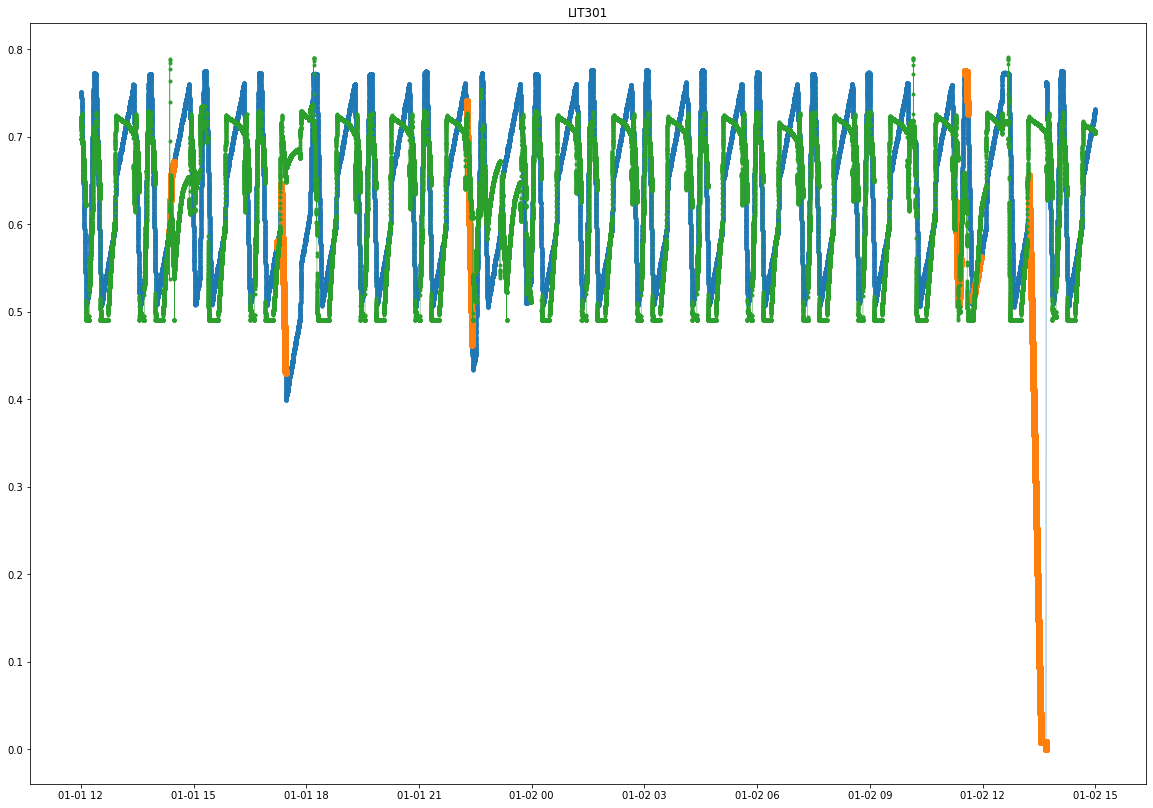

In [113]:
start, end = '2016-01-01 12:00:00', '2016-01-02 14:59:59'
attacks_timestamps_interval = attacks_timestamps[(attacks_timestamps > start)]

fig, ax = plt.subplots(1, 1, figsize=(20, 14), sharex=True)
name = "LIT301"
ax.plot(test_df_with_predicted_from_file.loc[start:end, name], marker='.', linestyle='-', linewidth=0.5, label=name)
ax.plot(test_df_with_predicted_from_file.loc[attacks_timestamps_interval, name], marker='o', linestyle='None')
ax.plot(test_df_with_predicted_from_file.loc[start:end, "Predicted"], marker='.', linestyle='-', linewidth=0.5, )

ax.set_title(name)

In [47]:
test_df_with_predicted.to_csv('LIT301_sensor_strategy.csv', index=True)

## Plot for "CLassification" Strategy


---

Text(0.5, 1.0, 'LIT301')

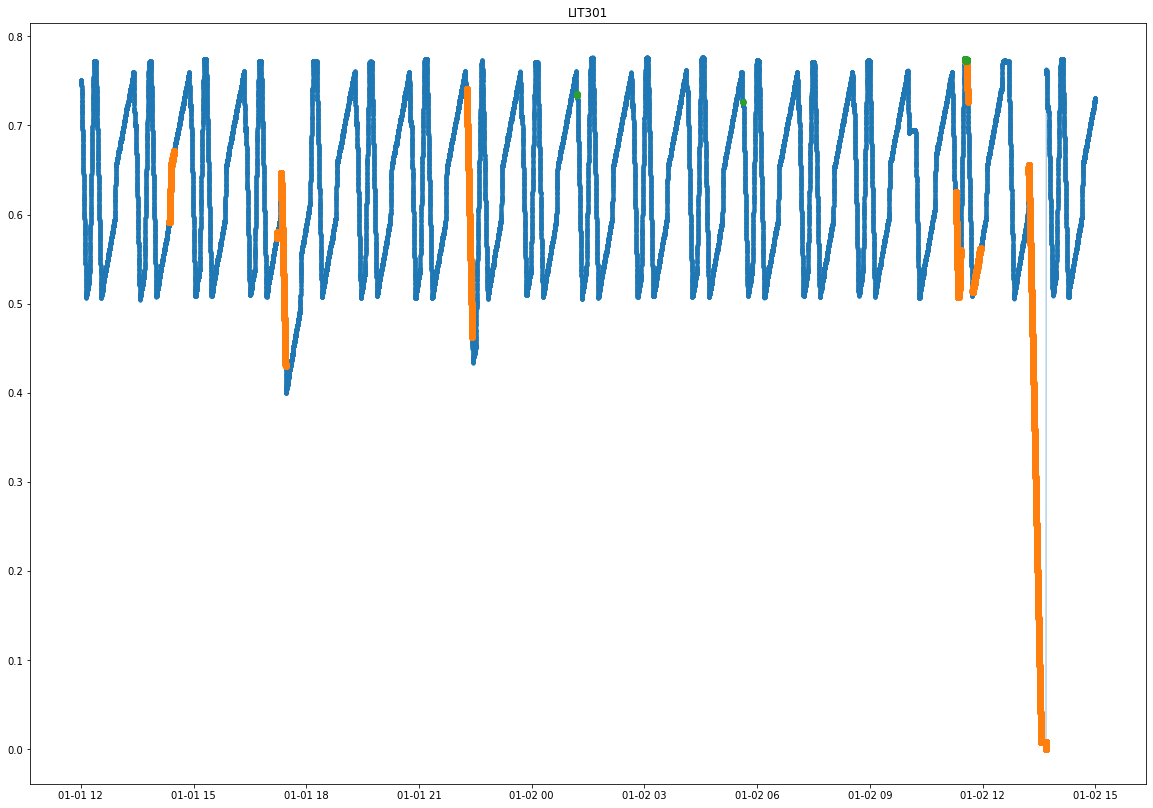

In [99]:
start, end = '2016-01-01 12:00:00', '2016-01-02 14:59:59'
attacks_timestamps_interval = attacks_timestamps[(attacks_timestamps > start)]
predicted_attacks_timestamps = test_df_with_predicted.loc[test_df_with_predicted['PredictedAttack'] == 1].index

fig, ax = plt.subplots(1, 1, figsize=(20, 14), sharex=True)
name = "LIT301"
ax.plot(test_df_with_predicted.loc[start:end, name], marker='.', linestyle='-', linewidth=0.5, label=name)
ax.plot(test_df_with_predicted.loc[attacks_timestamps_interval, name], marker='o', linestyle='None')
ax.plot(test_df_with_predicted.loc[predicted_attacks_timestamps, name], marker='o', linestyle='None')

ax.set_title(name)

In [96]:
test_df_with_predicted.to_csv('Prediction_results.csv', index=True)